# Problem 2: MNIST: Hand-written digit classification

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

## Loading MNIST
The `torchvision` module contains links to many standard datasets. We can load the MNIST dataset into a `Dataset` object as follows:

In [ ]:
train_dataset = datasets.MNIST('./data', train=True, download=True,  # Downloads into a directory ../data
                               transform=transforms.ToTensor())
train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, 
                                                             [int(len(train_dataset)*0.8), int(len(train_dataset)*0.2)], 
                                                             generator=torch.Generator().manual_seed(42))
test_dataset = datasets.MNIST('./data', train=False, download=False,  # No need to download again
                              transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



The `Dataset` object is an iterable where each element is a tuple of (input `Tensor`, target):

In [ ]:
print(train_dataset[0][0])

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1098, 0.2627, 0.9490, 0.9961, 1.0000,

In [ ]:
type(train_dataset[0][1])

int

2a) Structure of the dataset

In [ ]:
print(train_dataset[0][0][0].shape)

torch.Size([28, 28])


In [ ]:
print(28*28)

784


The height and width of the images are 28 by 28. There is one channel per image. The values in the first array index represent the sample point as a tuple. The second index represent the tensor including the training data, the third value in the index represent the actual training data

In [ ]:
print(len(train_dataset))

48000


In [ ]:
print(len(valid_dataset))

12000


There are 48000 images in the training set, 12000 images in the testing set.

We can convert images to numpy arrays and plot them with matplotlib:

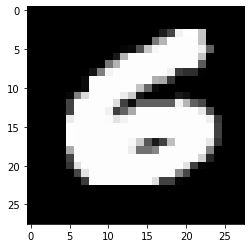

In [ ]:
plt.imshow(train_dataset[0][0][0].numpy(), cmap='gray')

## Example linear model
Let's instantiate a linear model and take a look at the layers.

In [ ]:
model = nn.Sequential(
    # For fully-connected networks, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784, 10),
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)


## Training and validation

Now let's try to train the linear model as an example.

In [ ]:
def run_training_loop(model, batch_size=32, n_epochs=10, lr=1e-3):

    # We could write our training procedure manually and directly index the `Dataset` objects,
    # but the `DataLoader` object conveniently creates an iterable for automatically creating random minibatches:
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

    # Choose Adam as the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    # store metrics
    train_loss_history = np.zeros([n_epochs, 1])
    valid_accuracy_history = np.zeros([n_epochs, 1])
    valid_loss_history = np.zeros([n_epochs, 1])

    for epoch in range(n_epochs):

        # Some layers, such as Dropout, behave differently during training
        model.train()

        train_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):

            # Erase accumulated gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)

            # Calculate loss
            loss = loss_fn(output, target)
            train_loss += loss.item()

            # Backward pass
            loss.backward()
            
            # Weight update
            optimizer.step()

        train_loss_history[epoch] = train_loss / len(train_loader.dataset)

        # Track loss each epoch
        print('Train Epoch: %d  Average loss: %.4f' %
              (epoch + 1,  train_loss_history[epoch]))

        # Putting layers like Dropout into evaluation mode
        model.eval()

        valid_loss = 0
        correct = 0

        # Turning off automatic differentiation
        with torch.no_grad():
            for data, target in valid_loader:
                output = model(data)
                valid_loss += loss_fn(output, target).item()  # Sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
                correct += pred.eq(target.view_as(pred)).sum().item()

        valid_loss_history[epoch] = valid_loss / len(valid_loader.dataset)
        valid_accuracy_history[epoch] = correct / len(valid_loader.dataset)

        print('Valid set: Average loss: %.4f, Accuracy: %d/%d (%.4f)\n' %
              (valid_loss_history[epoch], correct, len(valid_loader.dataset),
              100. * valid_accuracy_history[epoch]))
    
    return model, train_loss_history, valid_loss_history, valid_accuracy_history

Train Epoch: 1  Average loss: 0.0155
Valid set: Average loss: 0.0109, Accuracy: 10844/12000 (90.3667)

Train Epoch: 2  Average loss: 0.0097
Valid set: Average loss: 0.0100, Accuracy: 10905/12000 (90.8750)

Train Epoch: 3  Average loss: 0.0089
Valid set: Average loss: 0.0095, Accuracy: 10960/12000 (91.3333)

Train Epoch: 4  Average loss: 0.0085
Valid set: Average loss: 0.0093, Accuracy: 11017/12000 (91.8083)

Train Epoch: 5  Average loss: 0.0083
Valid set: Average loss: 0.0092, Accuracy: 11016/12000 (91.8000)

Train Epoch: 6  Average loss: 0.0081
Valid set: Average loss: 0.0092, Accuracy: 11021/12000 (91.8417)

Train Epoch: 7  Average loss: 0.0080
Valid set: Average loss: 0.0092, Accuracy: 11014/12000 (91.7833)

Train Epoch: 8  Average loss: 0.0079
Valid set: Average loss: 0.0092, Accuracy: 11026/12000 (91.8833)

Train Epoch: 9  Average loss: 0.0078
Valid set: Average loss: 0.0094, Accuracy: 10983/12000 (91.5250)

Train Epoch: 10  Average loss: 0.0077
Valid set: Average loss: 0.0092, Ac

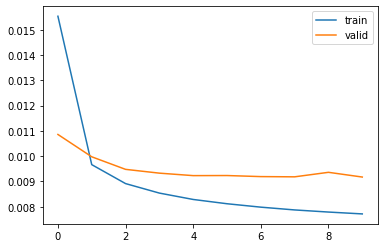

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

## Testing
After selecting hyperparameters from the validation set, evaluate on the held-out test set (distinct from the validation set).

In [ ]:
def test_performance(model, batch_size=32):
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

    # Putting layers like Dropout into evaluation mode
    model.eval()
    # Use the cross entropy loss function
    loss_fn = nn.CrossEntropyLoss()

    test_loss = 0
    correct = 0

    # Turning off automatic differentiation
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / len(test_loader.dataset)

    print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
          (test_loss, correct, len(test_loader.dataset),
          100. * test_accuracy))
    return test_loss, test_accuracy

In [ ]:
test_performance(model)

Test set: Average loss: 0.0084, Accuracy: 9258/10000 (92.5800)


(0.008356586967408658, 0.9258)

Not bad! Even the linear model gets above 92% accuracy.

## Visualizing predictions

We can visualize and inspect the model predictions. Here is an example of how to visualize the wrongly classified cases among the first 20 validation examples.

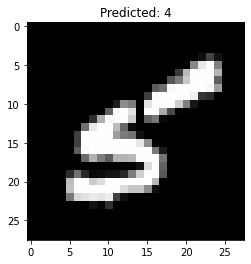

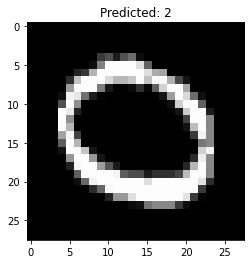

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

# Turning off automatic differentiation
with torch.no_grad():
      for i in range(20):
        data, target = valid_dataset[i]
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        if pred.item() != target:
            plt.imshow(data[0].numpy(), cmap='gray')
            plt.title(f'Predicted: {pred.item()}')
            plt.show()

# Your code: 2 (b)

In [ ]:
model = nn.Sequential(
    # In problem 2, we don't use the 2D structure of an image at all. Our network
    # takes in a flat vector of the pixel values as input.
    nn.Flatten(),  
    nn.Linear(784,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,10),
    # TODO
)


Train Epoch: 1  Average loss: 0.0097
Valid set: Average loss: 0.0051, Accuracy: 11410/12000 (95.0833)

Train Epoch: 2  Average loss: 0.0040
Valid set: Average loss: 0.0039, Accuracy: 11554/12000 (96.2833)

Train Epoch: 3  Average loss: 0.0028
Valid set: Average loss: 0.0037, Accuracy: 11564/12000 (96.3667)

Train Epoch: 4  Average loss: 0.0021
Valid set: Average loss: 0.0034, Accuracy: 11612/12000 (96.7667)

Train Epoch: 5  Average loss: 0.0017
Valid set: Average loss: 0.0031, Accuracy: 11641/12000 (97.0083)

Train Epoch: 6  Average loss: 0.0014
Valid set: Average loss: 0.0030, Accuracy: 11666/12000 (97.2167)

Train Epoch: 7  Average loss: 0.0011
Valid set: Average loss: 0.0029, Accuracy: 11674/12000 (97.2833)

Train Epoch: 8  Average loss: 0.0009
Valid set: Average loss: 0.0035, Accuracy: 11657/12000 (97.1417)

Train Epoch: 9  Average loss: 0.0008
Valid set: Average loss: 0.0032, Accuracy: 11684/12000 (97.3667)

Train Epoch: 10  Average loss: 0.0007
Valid set: Average loss: 0.0032, Ac

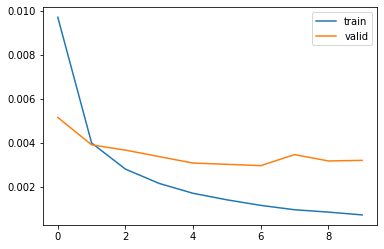

Test set: Average loss: 0.0029, Accuracy: 9759/10000 (97.5900)


(0.0029353247437373282, 0.9759)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

I implemented a feedforward model with 2 hidden layers each with 100 units and each with bias. With ReLU activation for hidden layers and no softmax activation for the final layer. No regularization is used as there is no overfitting.

# Example code for convolutional neural networks

In [ ]:
# sample model
import torch.nn as nn

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(8,8)),
    nn.ReLU(),
    nn.MaxPool2d(8),
    nn.Dropout(p=0.5),
    
    nn.Flatten(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
    # PyTorch implementation of cross-entropy loss includes softmax layer
)

# take a look at the shape of the weights for each layer
for p in model.parameters():
    print(p.data.shape)


# our model has some # of parameters:
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

torch.Size([8, 1, 8, 8])
torch.Size([8])
torch.Size([64, 32])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])
total params: 3282


Train Epoch: 1  Average loss: 0.0370
Valid set: Average loss: 0.0161, Accuracy: 10475/12000 (87.2917)

Train Epoch: 2  Average loss: 0.0259
Valid set: Average loss: 0.0133, Accuracy: 10701/12000 (89.1750)

Train Epoch: 3  Average loss: 0.0233
Valid set: Average loss: 0.0108, Accuracy: 10935/12000 (91.1250)

Train Epoch: 4  Average loss: 0.0220
Valid set: Average loss: 0.0099, Accuracy: 11011/12000 (91.7583)

Train Epoch: 5  Average loss: 0.0210
Valid set: Average loss: 0.0092, Accuracy: 11003/12000 (91.6917)

Train Epoch: 6  Average loss: 0.0204
Valid set: Average loss: 0.0092, Accuracy: 11093/12000 (92.4417)

Train Epoch: 7  Average loss: 0.0200
Valid set: Average loss: 0.0093, Accuracy: 11077/12000 (92.3083)

Train Epoch: 8  Average loss: 0.0195
Valid set: Average loss: 0.0086, Accuracy: 11083/12000 (92.3583)

Train Epoch: 9  Average loss: 0.0190
Valid set: Average loss: 0.0084, Accuracy: 11116/12000 (92.6333)

Train Epoch: 10  Average loss: 0.0186
Valid set: Average loss: 0.0084, Ac

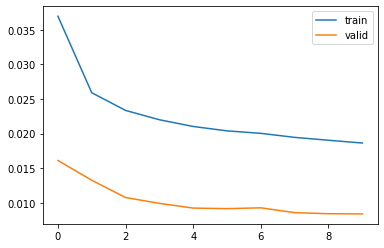

Test set: Average loss: 0.0076, Accuracy: 9385/10000 (93.8500)


(0.0075802268877625464, 0.9385)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

## Your code: 2 (c)

In [ ]:
from torch.nn.modules.activation import Softmax
from torch.nn.modules.flatten import Flatten
from torch.nn.modules.batchnorm import BatchNorm2d
model = nn.Sequential(
    # TODO
    nn.Conv2d(1,32, kernel_size = (6,6), stride = 2, padding=(3,3)),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2, padding=(1,0)),

    nn.Conv2d(32,44, kernel_size = (5,5)),
    nn.BatchNorm2d(44),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2),

    nn.Flatten(),
    nn.Linear(88, 64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(64, 10),
    # nn.Softmax()
)

# make sure the # of parameters is under 50,000
count = 0
for p in model.parameters():
    n_params = np.prod(list(p.data.shape)).item()
    count += n_params
print(f'total params: {count}')

total params: 42926


Train Epoch: 1  Average loss: 0.0078
Valid set: Average loss: 0.0023, Accuracy: 11719/12000 (97.6583)

Train Epoch: 2  Average loss: 0.0028
Valid set: Average loss: 0.0016, Accuracy: 11796/12000 (98.3000)

Train Epoch: 3  Average loss: 0.0021
Valid set: Average loss: 0.0015, Accuracy: 11829/12000 (98.5750)

Train Epoch: 4  Average loss: 0.0018
Valid set: Average loss: 0.0014, Accuracy: 11842/12000 (98.6833)

Train Epoch: 5  Average loss: 0.0015
Valid set: Average loss: 0.0013, Accuracy: 11858/12000 (98.8167)

Train Epoch: 6  Average loss: 0.0013
Valid set: Average loss: 0.0014, Accuracy: 11857/12000 (98.8083)

Train Epoch: 7  Average loss: 0.0011
Valid set: Average loss: 0.0014, Accuracy: 11853/12000 (98.7750)

Train Epoch: 8  Average loss: 0.0010
Valid set: Average loss: 0.0015, Accuracy: 11862/12000 (98.8500)

Train Epoch: 9  Average loss: 0.0009
Valid set: Average loss: 0.0015, Accuracy: 11858/12000 (98.8167)

Train Epoch: 10  Average loss: 0.0008
Valid set: Average loss: 0.0015, Ac

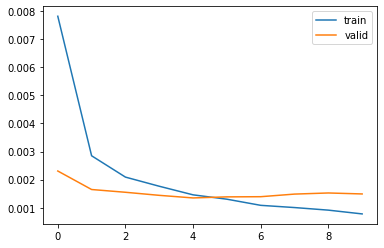

Test set: Average loss: 0.0012, Accuracy: 9891/10000 (98.9100)


(0.0011938044245494211, 0.9891)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

I used 2 convolution layers with strides and max pooling to increase the receptive fields of the final output. I also applied batch norm to regularize the convolution output to make model less sensitive to higher learning rates and initialization. I then implemented a feedforward neural network with one hidden layer and used dropout in the last step as regularization before I get to the final output layer. I tried the model with and without batch normalization and found out that batch normalization significantly improved the accuracy. I also tried adding and deleting softmax as the activation function for the output and I found that deleting softmax gives a better result.  

# Problem 3: Vision Transformer

In [ ]:
!pip install einops

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 524 kB/s 


## Your code: 3(a)

Implement single-head attention.

In [ ]:
class SingleHeadAttention(nn.Module):
    def __init__(self, input_dim, inner_dim, dropout = 0.):
        super().__init__()
        # TODO
        self.q = nn.Linear(input_dim, inner_dim)
        self.k = nn.Linear(input_dim, inner_dim)
        self.v = nn.Linear(input_dim, inner_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.softmax = nn.Softmax(dim=-1)
        self.d_k = inner_dim

    def forward(self, x):
        # TODO
        Q = self.q(x)
        K = self.k(x)
        V = self.v(x)

        attn_weights = self.softmax(torch.matmul(Q, torch.transpose(K, -2, -1)) / np.sqrt(self.d_k))
        out = torch.matmul(attn_weights, V)
        
        out = self.dropout(out)

        return out, attn_weights

In [ ]:
# model.transformer[5].attn[1].attention_heads[0].attentionmatrix

Test the following multihead attention implementation that relies on the single-head attention implementation above.

In [ ]:
class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        self.attention_heads = nn.ModuleList([
            SingleHeadAttention(dim, dim_head, dropout=dropout)
            for _ in range(heads)
        ])

    def forward(self, x):
        outputs = [head(x) for head in self.attention_heads]
        out = torch.cat([output[0] for output in outputs], dim=-1)
        attn_matrix = torch.stack([output[1] for output in outputs])
        return out, attn_matrix

Test code for multihead attention:

In [ ]:
T = 5
input_dim = 32
batch_size = 20

heads = 8
dim_head = 64

test_input = torch.zeros((batch_size, T, input_dim))

test_attention_module = Attention(input_dim)
test_output, test_attn_matrix = test_attention_module(test_input)

print(test_output)
assert test_output.size() == (batch_size, T, heads * dim_head), "Shapes are incorrect"

tensor([[[-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748]],

        [[-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748]],

        [[-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
         [-0.1573,  0.1000, -0.0021,  ..., -0.1420,  0.1038, -0.1748],
  

## Your code: 3 (b)

In [ ]:
class ViTLayer(nn.Module):
    def __init__(self, dim, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.attn = nn.Sequential(
            # TODO
            nn.LayerNorm(dim),
            Attention(dim=dim,heads=heads, dim_head=dim_head, dropout=dropout),
        )
        self.feedforward = nn.Sequential(
            # TODO
            nn.LayerNorm(dim),
            #A
            nn.Linear(dim,mlp_dim),
            nn.Dropout(p=dropout),
            #Relu
            nn.ReLU(),
            #B
            nn.Linear(mlp_dim,dim),
            #dropout
            nn.Dropout(p=dropout)
        )
        self.attn_project = nn.Linear(heads*dim_head,dim)

    def forward(self, x):
        # TODO
        outattn, attn_matrix = self.attn(x)
        outattn = self.attn_project(outattn) + x
        #apply feedforward
        outmlp = self.feedforward(outattn)
        out = outattn + outmlp
        return out, attn_matrix
  

## ViT code for 3 (c)

In [ ]:
class ViT(nn.Module):
    def __init__(self, patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128, 
                 dim_head = 64,
                 dropout = 0., emb_dropout = 0.):
        super().__init__()

        image_height, image_width = 28, 28
        num_classes = 10
        channels = 1

        patch_height = patch_size
        patch_width = patch_size

        assert image_height % patch_height == 0 and image_width % patch_width == 0, (
            'Image dimensions must be divisible by the patch size.')

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.emb_dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.Sequential(*nn.ModuleList([
            ViTLayer(dim, heads, dim_head, mlp_dim, dropout)
            for _ in range(depth)                       
        ]))

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img, return_attn_matrix = False):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.emb_dropout(x)
        for layer in self.transformer:
          x, attn_matrix = layer(x)

        x = x[:, 0]
        if return_attn_matrix:
          return self.mlp_head(x), attn_matrix
        else:
          return self.mlp_head(x)

In [ ]:
model = ViT(patch_size=7, dim=64, depth=6, heads=8, mlp_dim=128)

Train Epoch: 1  Average loss: 0.0107
Valid set: Average loss: 0.0051, Accuracy: 11433/12000 (95.2750)

Train Epoch: 2  Average loss: 0.0043
Valid set: Average loss: 0.0043, Accuracy: 11493/12000 (95.7750)

Train Epoch: 3  Average loss: 0.0036
Valid set: Average loss: 0.0034, Accuracy: 11616/12000 (96.8000)

Train Epoch: 4  Average loss: 0.0029
Valid set: Average loss: 0.0030, Accuracy: 11642/12000 (97.0167)

Train Epoch: 5  Average loss: 0.0026
Valid set: Average loss: 0.0032, Accuracy: 11624/12000 (96.8667)

Train Epoch: 6  Average loss: 0.0024
Valid set: Average loss: 0.0034, Accuracy: 11601/12000 (96.6750)

Train Epoch: 7  Average loss: 0.0021
Valid set: Average loss: 0.0028, Accuracy: 11684/12000 (97.3667)

Train Epoch: 8  Average loss: 0.0019
Valid set: Average loss: 0.0029, Accuracy: 11671/12000 (97.2583)

Train Epoch: 9  Average loss: 0.0016
Valid set: Average loss: 0.0029, Accuracy: 11659/12000 (97.1583)

Train Epoch: 10  Average loss: 0.0016
Valid set: Average loss: 0.0025, Ac

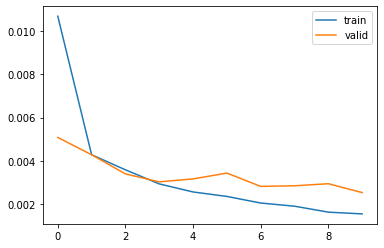

Test set: Average loss: 0.0025, Accuracy: 9752/10000 (97.5200)


(0.002481721274758456, 0.9752)

In [ ]:
trained_model, train_loss_history, valid_loss_history, valid_accuracy_history = run_training_loop(model)
plt.plot(train_loss_history, label='train')
plt.plot(valid_loss_history, label='valid')
plt.legend()
plt.show()

test_performance(model)

Text(0.5, 0.98, 'validation attention weights for 8 heads')

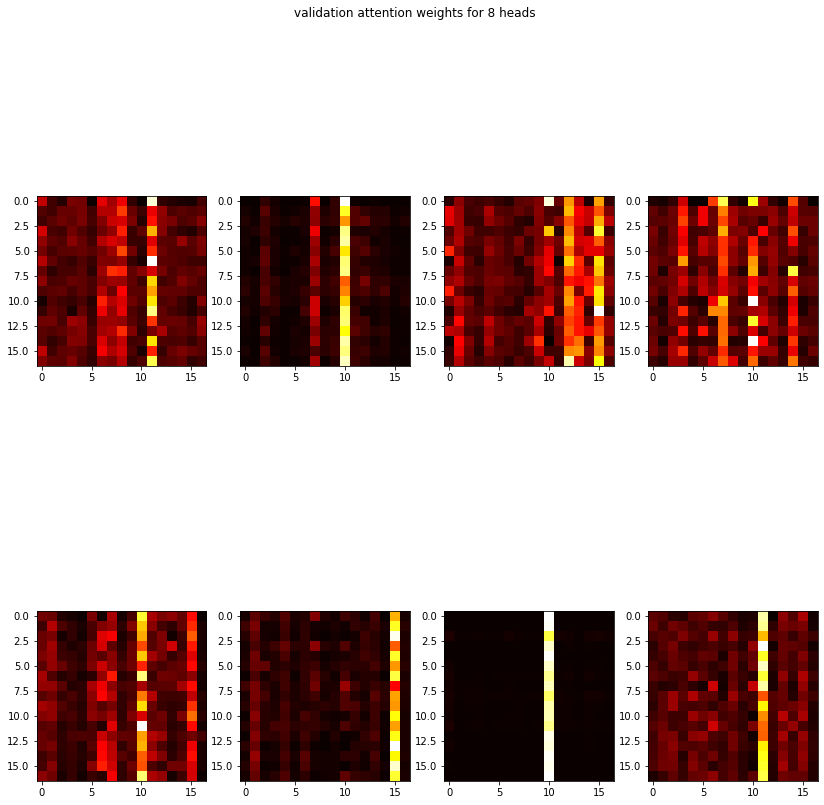

In [ ]:
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
with torch.no_grad():
  for data, target in valid_loader:
      output, attn_matrix = trained_model(data, return_attn_matrix = True)
      break

matrix = []
for i in attn_matrix:
  i = torch.mean(i,0)
  matrix.append(i)
  
fig, ax = plt.subplots(2, 4, figsize=(14,14))
for i in np.arange(2):
    for j in np.arange(4):
        ax[i,j].imshow(matrix[j+4*i],cmap = "hot")
fig.suptitle("validation attention weights for 8 heads")